# Monthly Fracture Maps

Next, we will pair the stress maps with a monthly time series of fracture maps from Surawy et al.

**UPDATES:**
- Parcel tracking
- Area Tracking
- Defining "fractured"

## Import Packages

In [1]:
import geopandas as gpd
import numpy as np
import xarray as xr
import rioxarray as rxr

from shapely.geometry import Polygon
from shapely.geometry import Point
import matplotlib.pyplot as plt

import json
import blue_ice_tools as bit
import itslivetools
import imageio

# silence runtime warnings
import warnings
warnings.filterwarnings("ignore")

## Load in Shapefile, Velocity Data, and compute Stress

In [2]:
# Read in shapefile of Shirase Glacier
shirase_shape = gpd.read_file('../data/shirase-glacier/shirase.shp')

# Load in ITS_LIVE velocities with shape
shirase_stress = bit.get_data_cube(shape=shirase_shape, epsg=3031, dt_delta=19).compute()

# Call stress function
shirase_stress = bit.compute_strain_stress(shirase_stress, sav_gol=True, rotate=True)
shirase_stress

Computing stresses       : 100%|██████████| 1/1 [00:02<00:00,  2.82s/it]


<xarray.Dataset> Size: 2GB
Dimensions:      (mid_date: 299, y: 655, x: 328)
Coordinates:
  * x            (x) float64 3kB 1.344e+06 1.344e+06 ... 1.383e+06 1.384e+06
  * y            (y) float64 5kB 1.649e+06 1.65e+06 ... 1.728e+06 1.728e+06
    spatial_ref  int64 8B 0
    mapping      int64 8B 0
  * mid_date     (mid_date) datetime64[ns] 2kB 1999-12-31 ... 2024-10-31
Data variables:
    vx           (mid_date, y, x) float32 257MB nan nan nan nan ... nan nan nan
    vy           (mid_date, y, x) float32 257MB nan nan nan nan ... nan nan nan
    v            (mid_date, y, x) float32 257MB nan nan nan nan ... nan nan nan
    effective    (mid_date, y, x) float32 257MB nan nan nan nan ... nan nan nan
    eps_xx       (mid_date, y, x) float32 257MB nan nan nan nan ... nan nan nan
    eps_yy       (mid_date, y, x) float32 257MB nan nan nan nan ... nan nan nan
    von_mises    (mid_date, y, x) float32 257MB nan nan nan nan ... nan nan nan
    sigma1       (mid_date, y, x) float32 257MB nan nan nan nan ... nan nan nan
    sigma2       (mid_date, y, x) float32 257MB nan nan nan nan ... nan nan nan
Attributes: (12/19)
    Conventions:                CF-1.8
    GDAL_AREA_OR_POINT:         Area
    author:                     ITS_LIVE, a NASA MEaSUREs project (its-live.j...
    autoRIFT_parameter_file:    http://its-live-data.s3.amazonaws.com/autorif...
    datacube_software_version:  1.0
    date_created:               26-Sep-2023 13:16:09
    ...                         ...
    s3:                         s3://its-live-data/datacubes/v2/S70E030/ITS_L...
    skipped_granules:           s3://its-live-data/datacubes/v2/S70E030/ITS_L...
    time_standard_img1:         UTC
    time_standard_img2:         UTC
    title:                      ITS_LIVE datacube of image pair velocities
    url:                        https://its-live-data.s3.amazonaws.com/datacu...

## Load in Fracture Maps

With the fracture maps, we have almost 5 years of consecutive data.

In [3]:
fracture = xr.open_dataset('../data/shirase-glacier/shirase-fracture-clipped.nc')
fracture

<xarray.Dataset> Size: 93MB
Dimensions:        (mid_date: 54, y: 655, x: 328)
Coordinates:
  * mid_date       (mid_date) datetime64[ns] 432B 2018-07-31 ... 2023-01-31
    spatial_ref    int64 8B ...
  * x              (x) float64 3kB 1.344e+06 1.344e+06 ... 1.383e+06 1.384e+06
  * y              (y) float64 5kB 1.649e+06 1.65e+06 ... 1.728e+06 1.728e+06
    mapping        int64 8B ...
Data variables:
    fracture_conf  (mid_date, y, x) float64 93MB ...

The fracture data ranges from July 2018 to January 2023. Let's take a quick look at one of these composites

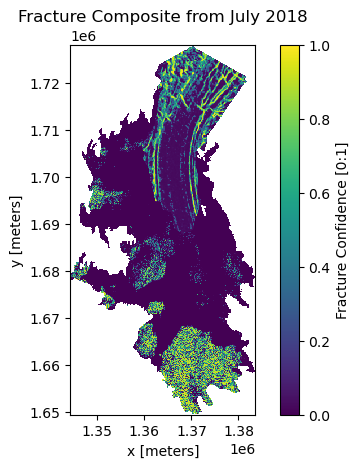

In [4]:
fig, ax = plt.subplots()

fracture.fracture_conf[0].plot(ax=ax, vmax=1, vmin=0, cbar_kwargs={'label':'Fracture Confidence [0:1]'})
ax.set_title('Fracture Composite from July 2018')
ax.set_aspect('equal')
ax.set_xlabel('x [meters]')
ax.set_ylabel('y [meters]')

plt.show()

These composites cover the entire area of Shirase Glacier. The CNN has better picks over ungrounded ice than it does over grounded ice, which is an important feature to keep in mind. <br>

Now, let's merge them with the ITS_LIVE velocity data. The fracture dataset has dates ranging from July 2018-January 2023. We'll want to clip the velocity dataset to match this range before merging the datasets. Since the two datasets have the exact same time dimensions, we can use `xr.merge`.

In [5]:
# Select the slice of dates that are covered by the fracture dataset
shirase_stress = shirase_stress.sel(mid_date=slice(fracture.mid_date[0], fracture.mid_date[-1]))

# merge datasets using xr.merge
shirase_ds = xr.merge([fracture, shirase_stress])

## Time Series of Parcel - With Fracture Confidence

In the last notebook, we tracked a parcel as it moved through time. Now that we have data on how likely the ice is to be fractured, we can look at how the stresses change with respect to time and fracture.

We can look at the same parcel of ice as the last example in notebook 03. The coordinates are: `x, y = 1365000, 1714200`. We used this point it was easily identified as crevassed on November 30, 2020 (time index 28). 

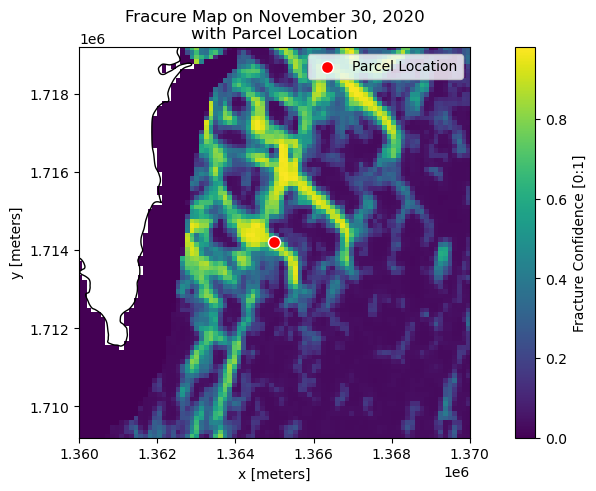

In [6]:
x1, y1 = 1365000, 1714200

fig, ax = plt.subplots(layout='constrained')

shirase_ds.fracture_conf[28].plot(ax=ax, cbar_kwargs={'label':'Fracture Confidence [0:1]'})
shirase_shape.plot(ax=ax, facecolor='none')

ax.scatter(x1, y1, s=75, c='r', ec='w', label='Parcel Location')

ax.set_xlabel('x [meters]')
ax.set_ylabel('y [meters]')
ax.set_xlim(x1-5000, x1+5000)
ax.set_ylim(y1-5000, y1+5000)

ax.legend()
ax.set_title('Fracure Map on November 30, 2020\nwith Parcel Location')

plt.show()

This plot shows where the parcel is located on the date it was identified. We can track this point both directions (forward and backward in time). We will pass `start_index=28`, and since we want to track through the entire dataset we will go 28 steps in reverse, and leave steps_forward as None. 

We want to average some of the noise out of the data. To do so, we will set `buffer=200`, which means the function will average 200 meters in **both directions** along the x- and y-axis.
- Takes all pixels within (x-200), (x+200), (y-200), and (y+200) and takes the mean.

In [7]:
# The point to be plotted on a time series, add buffer area around point
x, y = 1365000, 1714200
start_index = 28
buffer = 200

# select the area around the point, take a spatial mean
parcel, points = bit.parcel_strain_stress(shirase_ds, x, y, buffer=buffer, 
                                          start_index=start_index, steps_reverse=start_index)
parcel

Tracking Parcel: 100%|██████████| 55/55 [00:00<00:00, 404.60it/s]


<xarray.Dataset> Size: 4kB
Dimensions:           (mid_date: 55)
Coordinates:
  * mid_date          (mid_date) datetime64[ns] 440B 2018-07-31 ... 2023-01-31
    spatial_ref       int64 8B 0
    mapping           int64 8B 0
Data variables: (12/13)
    fracture_conf     (mid_date) float64 440B 0.3193 0.2791 ... 0.8395 0.791
    vx                (mid_date) float32 220B nan 378.8 ... 1.162e+03 1.121e+03
    vy                (mid_date) float32 220B nan 2.475e+03 ... 2.306e+03
    v                 (mid_date) float32 220B nan 2.505e+03 ... 2.566e+03
    effective         (mid_date) float32 220B nan nan 0.2153 ... 0.04169 0.04698
    eps_xx            (mid_date) float32 220B nan nan ... -0.04383 0.03425
    ...                ...
    von_mises         (mid_date) float32 220B nan nan 118.9 ... 326.2 436.3
    sigma1            (mid_date) float32 220B nan nan -15.77 ... -357.1 397.3
    sigma2            (mid_date) float32 220B nan nan -98.47 ... -263.0 443.9
    effective_strain  (mid_date) float32 220B 0.0 0.0 0.2153 ... 5.599 5.646
    e_xx              (mid_date) float32 220B 0.0 0.0 0.02227 ... 0.3143 0.3486
    e_yy              (mid_date) float32 220B 0.0 0.0 -0.04523 ... 1.175 1.224

As you can see above, there is only the time dimension. There are also three new variables. We integrated the strain rate with respect to time to obtain the full strain of the ice. 

We are going to do the same thing we did in the last notebook; make a GIF of the parcel moving through time. Instead of the stress field, we will plot the fracture map, and we will add markers to the timeseries that are color coded to match fracture confidence.

In [8]:
# Split points into x and y arrays
xs, ys = points.T
ticks = parcel.mid_date.dt.strftime('%Y-%m-%d').values

# Interate through dates
for i, date in enumerate(ticks):

    # grab x- and y- coord
    x, y = points[i].T

    fig, axs = plt.subplots(ncols=2, layout='constrained', figsize=(14,7), gridspec_kw={'width_ratios':[2,1], 'wspace':.01})
    ax1, ax2 = axs
    
    # Plot scatter plot and add connecting lines. 
    # Highlight current step w/vertical line
    ax1.plot(parcel.mid_date, parcel.von_mises, ls='-', c='k', alpha=0.5)
    ax1.scatter(parcel.mid_date, parcel.von_mises, c=parcel.fracture_conf)
    ax1.axvline(parcel.mid_date[i].data, c='k')

    # make the plot pretty
    ax1.set_title('Von Mises Stress with Fracture Confidence\n', 
                  weight='bold', fontsize=14)
    ax1.set_ylabel('$\sigma_{vm}$', fontsize=12)
    ax1.set_xticks(ticks[::6])
    ax1.set_xticklabels(ticks[::6], rotation=30)
    ax1.set_xlabel('Date', fontsize=12)
    ax1.grid(color='grey', ls='--', alpha=0.5)

    # Plot fracture map of current timestep, plot arrows, timestep location
    shirase_ds.fracture_conf[i].plot(ax=ax2, vmin=0, vmax=1, cbar_kwargs={'label':'Fracture Confidence [0:1]'})
    bit.plot_arrows(xs, ys, ax=ax2)
    ax2.scatter(x, y, c='r', ec='w', s=60, label='Parcel location')

    # make plot pretty
    ax2.set_title(f'Fracture Map and Parcel\non {date}', 
                  weight='bold', fontsize=14)
    ax2.set_xlim(xs.min()-1000, xs.max()+1000)
    ax2.set_ylim(ys.min()-1000, ys.max()+1000)
    ax2.set_xlabel('x [meters]', fontsize=12)
    ax2.set_ylabel('y [meters]', fontsize=12)
    ax2.set_aspect('equal')
    ax2.grid(color='grey', ls='--', alpha=0.5)
    ax2.legend()
    
    plt.savefig(f'../figures/gif-pngs/p1-{date}.png', dpi=300)
    plt.close()

pngs = [imageio.v2.imread(f'../figures/gif-pngs/p1-{date}.png') for date in ticks]

imageio.mimsave('../figures/shirase-glacier/04-p1.gif', pngs, duration=750, loop=0)

Let's look at the GIF we just made:

![Alt Text](../figures/shirase-glacier/04-p1.gif)

As you can see, the parcel marker perfectly follows the crevasse as it advects. While watching the movie, it appears that the crevasse opens at the end of 2019 or the very beginning of 2020. The Von Mises stress here clearly peaks 5 months before the fracture initially opens. After the fracture opens, the stresses continue to increase for a few months.

This process can easily be repeated for different parcels. By picking different x and y points from different timeslices, we can match many different regions and different stress environments to compare how the stresses change. 

Next, we can use the `bit.lagrangian_frame()` function to track an entire crevasse before and after it opens.

## Time Series of Single Crevasse

For this example, we will look at a region near the tongue of the glacier to find a crevasse as it opens, then track that crevasse through time. The majority of the glacier's flow is confined and ungrounded, so fractures are very unlikely to occur. Up at the tongue, the glacier finally flows into the open ocean, turns 45$^{\circ}$ to the right, and begins to fracture. 

Given the constraints of the CNN outputs and the fracture environments, this is the best area in the dataset to watch for crevasse opening. Let's clip the dataset to the upper regions.

In [9]:
# Clip shirase to the tongue region 
shirase_tongue = shirase_ds.isel(x=slice(109, -1), y=slice(327, -1))

Now that we have a slice of the tongue region of shirase, let's look at a few months before and after July 2020 and see if anything interesting happens

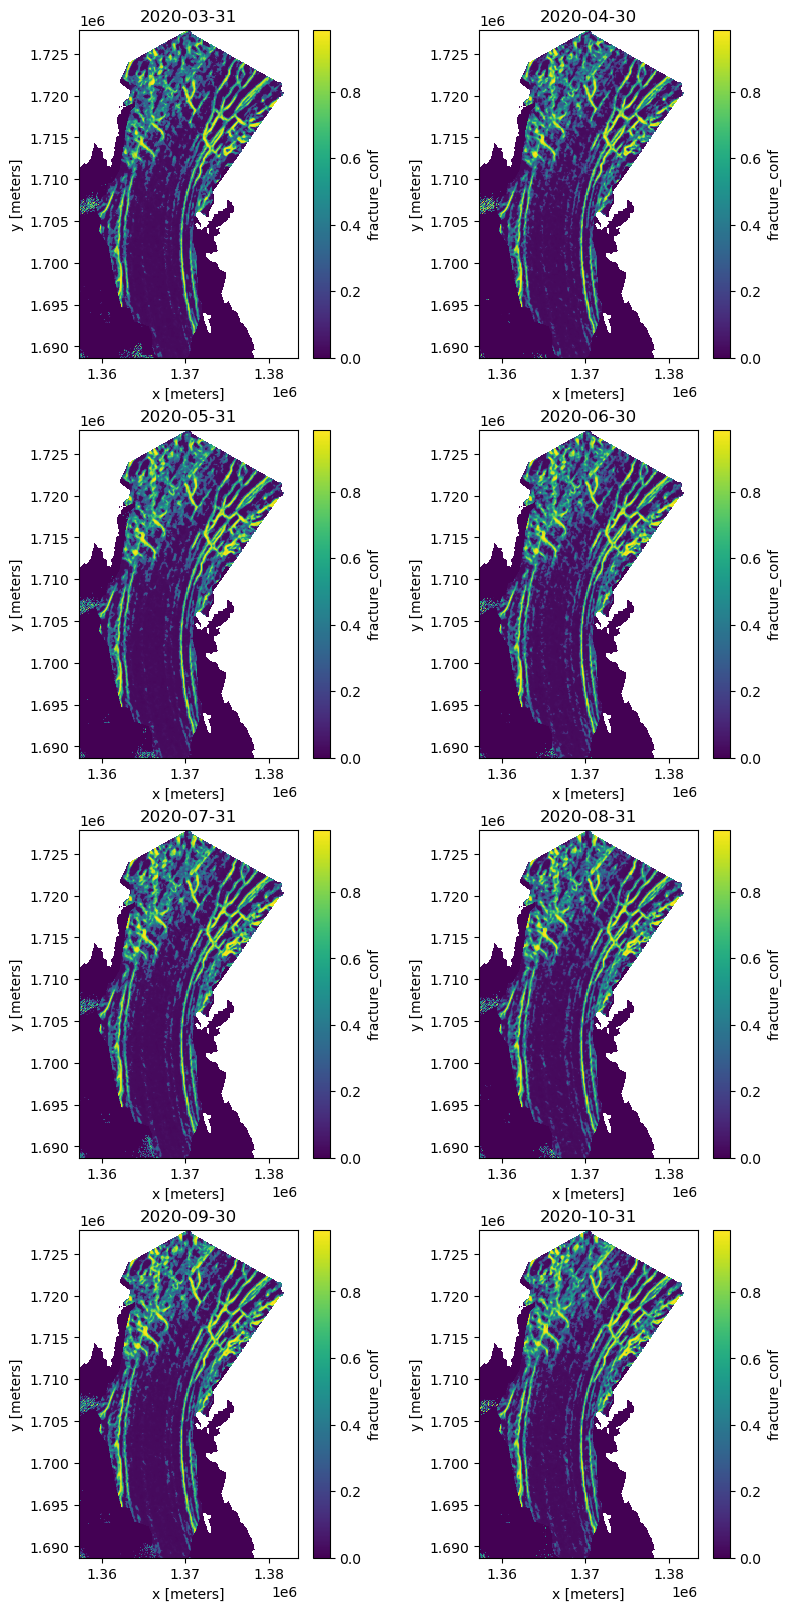

In [10]:
fig, axs = plt.subplots(ncols=2, nrows=4, figsize=(8,16), layout='constrained')
axs = axs.flatten()
for i, ax in zip(range(-3, 5), axs):
    
    shirase_tongue.fracture_conf[23+i].plot(ax=ax)
    ax.set_title(f'{np.datetime64(shirase_tongue.mid_date[23 + i].data, "D")}')
    ax.set_aspect('equal')
    ax.set_xlabel('x [meters]')
    ax.set_ylabel('y [meters]')
plt.show()

At around 1.715e6 in the y-coordinate, there are two 'hooks'. These two crevasses are rather large and have a 45$^{\circ}$ kink towards the end. There are only two of them in March. By October, there are 3 of them. This means a third hook crevasse opened up in this 8 month period. 

I would like to take a closer look at this crevasse as it moves through time to see if there are any interesting stresses happening here. I drew a shapely polygon around the crevasse from July 2022, which is the mid_date index of 48 for this dataset. A plot of this is shown below:

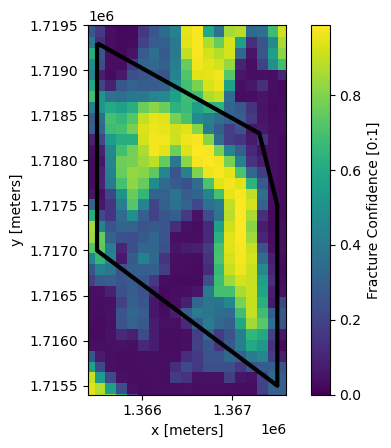

In [11]:
start_index = 48
# polygon of single crevasse and the area around
geom = Polygon([
    (1.3655e6, 1.7193e6),
    (1.3655e6, 1.717e6),
    (1.3675e6, 1.7155e6),
    (1.3675e6, 1.7175e6),
    (1.3673e6, 1.7183e6),
])
gdf = gpd.GeoDataFrame(geometry=[geom], crs='EPSG:3031')

fig, ax = plt.subplots()

shirase_ds.fracture_conf[start_index].plot(ax=ax, cbar_kwargs={'label':'Fracture Confidence [0:1]'})
gdf.plot(ax=ax, facecolor='none', lw=3)
ax.set_xlim(1.3654e6, 1.3676e6)
ax.set_ylim(1.7154e6, 1.7195e6)
ax.set_title(None)
ax.set_xlabel('x [meters]')
ax.set_ylabel('y [meters]')

plt.show()

By waiting until a later frame of the dataset, we are able to clip the crevasse at its largest size. This way, we don't miss any vital information. 

Next, we can use the function `bit.lagrangian_frame` to follow this parcel of ice as it flows on a montly timescale. Let's take a look at that function below.

In [12]:
bit.lagrangian_frame?

Signature:
bit.lagrangian_frame(
    ds: xarray.core.dataset.Dataset,
    geometry: shapely.geometry.polygon.Polygon,
    start_index: int = 0,
    steps_forward: int = None,
    steps_reverse: int = None,
    epsg: int = 3031,
    filtersize: int = None,
    remove_threshold: float = None,
) -> xarray.core.dataset.Dataset
Docstring:
Tracks a moving polygonal feature over time within a spatial dataset, leveraging velocity data to predict changes 
in the feature's geometry.

The function iteratively updates a given polygonal geometry to reflect its movement across time steps within an 
`xarray.Dataset`. The dataset is expected to contain velocity components (`vx` and `vy`) which guide the movement 
of the polygon. Additional parameters enable filtering of the dataset, handling of fracture points, and temporal 
movement both forward and backward.

Parameters:
-----------
ds : xr.Dataset
    The dataset containing velocity fields `vx` and `vy`, and a temporal dimension `mid_date`. 
    It

The required parameters of this function are an xarray dataset containing velocity components, such as our ITS_LIVE data, and a shapely polygon. The shapely polygon should outline a region or feature of interest. The function will take the velocity values at each point of the shapely polygon, then move them the appropriate distance, and clip the dataset. For each frame, the function applies the scipy median_filter, which smooths the image, making it easier to understand the small scall image.

Optional parameters:
- `start_index`: the mid_date index where the polygon was drawn. If drawn on the start index, or no value is passed, it will start from the beginning.
- `steps_forward`: the number of monthly time steps to track the feature going forward in time from the start index. If not passed, the function will track the remaining length of dataset.
- `steps_reverse`: the number of monthly time steps to track the feature going backward in time from the starting index. If not passed, the function will only track the area forward.
- `filtersize`: size of the windows in the median filter. The larger the number, the smoother the image will be. The default of 2 works very well.
- `remove_threshold`: more advanced parameter. This will remove any pixels that have been identified as fractured from the remainder of the dataset. 
    - Follows Grinsted, 2018 with the idea what crevasses that have already opened and moved are not a product to local stresses. Thus, only new fracturing cells are actually returned
 
The cell below contains the polygon shown above. I will demonstrate using the function in forward and reverse for a different number of timesteps. Since we want to see how the crevasse opened, we will track it all the way to the beginning of the dataset. That means `steps_reverse=start_index`. 

In [13]:
# index where the polygon was drawn to outline the crevasse
start_index = 48
# polygon of single crevasse and the area around
geom = Polygon([
    (1.3655e6, 1.7193e6),
    (1.3655e6, 1.717e6),
    (1.3675e6, 1.7155e6),
    (1.3675e6, 1.7175e6),
    (1.3673e6, 1.7183e6),
])

# call the lagrangian frame function reverse 35 steps and the full dataset foward
crevasse = bit.lagrangian_frame(
    shirase_ds, 
    geom, 
    start_index=start_index,  
    steps_reverse=47,
    remove_threshold=0.6,
    filtersize=1
)
crevasse

Tracking Polygon Over Time: 100%|██████████| 53/53 [00:28<00:00,  1.87it/s]


<xarray.Dataset> Size: 13MB
Dimensions:        (mid_date: 54, y: 117, x: 45)
Coordinates:
  * x              (x) float64 360B 1.363e+06 1.363e+06 ... 1.368e+06 1.368e+06
  * y              (y) float64 936B 1.706e+06 1.706e+06 ... 1.72e+06 1.72e+06
  * mid_date       (mid_date) datetime64[ns] 432B 2018-08-31 ... 2023-01-31
    mapping        int64 8B 0
    spatial_ref    int64 8B 0
Data variables:
    fracture_conf  (mid_date, y, x) float64 2MB nan nan nan nan ... nan nan nan
    vx             (mid_date, y, x) float32 1MB nan nan nan nan ... nan nan nan
    vy             (mid_date, y, x) float32 1MB nan nan nan nan ... nan nan nan
    v              (mid_date, y, x) float32 1MB nan nan nan nan ... nan nan nan
    effective      (mid_date, y, x) float32 1MB nan nan nan nan ... nan nan nan
    eps_xx         (mid_date, y, x) float32 1MB nan nan nan nan ... nan nan nan
    eps_yy         (mid_date, y, x) float32 1MB nan nan nan nan ... nan nan nan
    von_mises      (mid_date, y, x) float32 1MB nan nan nan nan ... nan nan nan
    sigma1         (mid_date, y, x) float32 1MB nan nan nan nan ... nan nan nan
    sigma2         (mid_date, y, x) float32 1MB nan nan nan nan ... nan nan nan

We now have a dataset that tracks this parcel of ice over 55 months! That's almost 5 years of data.

I would like to plot the time-varying failure envelope and find the yield stress of ice. To do so, we need to calculate a failure envelope that encompasses 95% of the non-fractured ice. Since there are a ton of `NaN`s in the dataset, we have to do a little bit of masking to ensure all points properly align.

In [14]:
# Pull P1 as xs, P2 as ys, confidence as cs
xs = crevasse.sigma1
ys = crevasse.sigma2
cs = crevasse.fracture_conf

# Compute the maximum absolute value in the dataset
max_extent = max(abs(xs.min()), abs(xs.max()), abs(ys.min()), abs(ys.max()))

# calculation of the Von Mises Failure envelope
# Mask is same remove threshold from above
mask = cs < .6
filtered_sigma1 = xs.where(mask).values.flatten()
filtered_sigma2 = ys.where(mask).values.flatten()

# Remove any NaNs to ensure alignment
valid_mask = ~np.isnan(filtered_sigma1) & ~np.isnan(filtered_sigma2)
filtered_sigma1 = filtered_sigma1[valid_mask]
filtered_sigma2 = filtered_sigma2[valid_mask]

# Calculate von Mises stress for each high-confidence point
von_mises_stresses = np.sqrt(filtered_sigma1**2 - filtered_sigma1 * filtered_sigma2 + filtered_sigma2**2)

# Determine the 95th percentile von Mises stress
vm_stress_cutoff = np.percentile(von_mises_stresses, 95)

# Create grid for plotting the envelope
sigma1_grid = np.linspace(xs.min(), xs.max(), 100)
sigma2_grid = np.linspace(ys.min(), ys.max(), 100)
sigma1_grid, sigma2_grid = np.meshgrid(sigma1_grid, sigma2_grid)
vm_grid = np.sqrt(sigma1_grid**2 - sigma1_grid * sigma2_grid + sigma2_grid**2)

print(f"Calculated Von Mises yield stress: {vm_stress_cutoff}")

Calculated Von Mises yield stress: 629.1498107910156


In the next cell, we are going to plot the parcel of ice as it moves, with a graph of the principle stress plotted against each other. We are also going to calculate a failure envelope for the entire dataset, such that any point identified as fractured should fall outside the envelop.

The grid and cutoff above will help us plot the Von Mises failure envelope.

In [15]:
from matplotlib.lines import Line2D

# Grab dates of crevasse to iterate through
dates = crevasse.mid_date.data
for i, date in enumerate(dates):
    # Create figure with 4 columns
    fig, axs = plt.subplots(ncols=4, figsize=(19,5), layout='constrained')
    ax1, ax2, ax3, ax4 = axs

    # Grab the principle stresses
    P1 = crevasse.sigma1[i]
    P2 = crevasse.sigma2[i]
    # Grab the fracture confidence of each point for a cmap
    c = crevasse.fracture_conf[i]

    # Plot P1 on the x- P2 on the y, coloring with fracture confidence
    ax1.scatter(x=P1, y=P2, c=c, cmap='viridis', vmax=1)
    ax1.set_xlim([-max_extent, max_extent])
    ax1.set_ylim([-max_extent, max_extent])
    ax1.axhline(0, color='k')
    ax1.axvline(0, color='k')
    contour = ax1.contour(sigma1_grid, sigma2_grid, vm_grid, levels=[vm_stress_cutoff], 
                          colors='red', linestyles='--', linewidths=2)

    # Add legend for Von Mises failure envelope
    legend_line = Line2D([0], [0], color='red', linestyle='--', linewidth=2, label=f'$\sigma_{{vm}} = {vm_stress_cutoff:.2f}$')
    ax1.legend(handles=[legend_line], loc='upper left')

    # Plot the princile stresses and fracture confidence as a map
    crevasse.fracture_conf[i].plot(ax=ax2, vmax=1, vmin=0, cbar_kwargs={'label':'Fracture Confidence [0:1]'})
    crevasse.sigma1[i].plot(ax=ax3, vmin=-max_extent, vmax=max_extent, cmap='RdBu', cbar_kwargs={'label':'Stress [kPa]'})
    crevasse.sigma2[i].plot(ax=ax4, vmin=-max_extent, vmax=max_extent, cmap='RdBu', cbar_kwargs={'label':'Stress [kPa'})

    # Set titles and aspects for each plot
    titles = ['Failure Map', 'Fracture Confidence', 'Principal Stress 1', 'Principal Stress 2']
    xlabels = ['$\sigma_1$ [kPa]', 'x [meters]', 'x [meters]', 'x [meters]']
    ylabels = ['$\sigma_2$ [kPa]', 'y [meters]', 'y [meters]', 'y [meters]']
    for ax, title, xlabel, ylabel in zip(axs, titles, xlabels, ylabels):
        ax.set_aspect('equal')
        ax.set_title(title, fontsize=14)
        ax.set_xlabel(xlabel, fontsize=12)
        ax.set_ylabel(ylabel, fontsize=12)
        ax.grid(c='gray', alpha=0.5, ls='--')

    plt.suptitle(f'Failure Map of Crevasse on {np.datetime64(date, "D")}', fontsize=16, weight='bold')
    plt.savefig(f'../figures/gif-pngs/04-c1-{i}.png')
    plt.close()

# # read in png files to imageio for gif
pngs = [imageio.v2.imread(f'../figures/gif-pngs/04-c1-{i}.png') for i in range(len(dates))]

# # use imageio to crease and save the gif to a local file
imageio.mimsave('../figures/shirase-glacier/04-c1.gif', pngs, duration=750, loop=0)

Now let's open up this tracked crevasse and see what's going on

![Crevasse GIF](../figures/shirase-glacier/04-c1.gif)

This GIF tracks a single piece of ice through time, showing how the stresses are acting on non-fractured ice.

## Conclusion

This is the final step of the framework. You know how to calculate stresses anywhere serviced by ITS_LIVE buckets and when paired with Fracture maps from Surawy et al, track crevasses and parcels of ice anywhere on Antarctica.